# Import packages

In [ ]:
# !pip install -r multiff_analysis/requirements.txt

In [18]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import general_utils, specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import cca_class, cca_utils, cca_cv_utils, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class, plot_gpfa_utils, decode_target_utils, fit_gpfa_utils, gpfa_regression_utils

import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
from numpy import var
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util




plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)

In [10]:
dec.get_x_and_y_var(exists_ok=True)
dec.reduce_y_var_lags(exists_ok=True)

Loaded x_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_x_var.csv
Loaded y_var from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var.csv
Loaded y_var_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_reduced.csv
Loaded x_var_lags and y_var_lags from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_x_var_lags.csv and all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags.csv
Loaded y_var_lags_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags_reduced.csv


In [11]:
dec.reduce_y_var_lags(exists_ok=False)

Computing reduced y_var_lags...

====================Dropping features with high correlation for each feature====================
Processing feature 1/61
10 columns out of 11 of *target_y* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *cum_distance* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *distance_from_monkey_pos_target_last_seen* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *target_index* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *valid_view_point_l* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
1 columns out of 11 of *gaze_mky_view_y_r* dropped: [-1]
10 columns out of 11 of *valid_view_point_r* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *target_last_seen_angle_to_boundary* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
10 columns out of 11 of *target_angle* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
Processing feature 11/61
10 columns out of 11 of *monkey_d

# add var

In [73]:
dec._make_or_retrieve_target_df()

Made new target_df


In [65]:
dec.get_basic_data()

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5


In [72]:
# add variable "capture" ff based on ff_caught_T_new, using searchsorted
target_capture_iloc = np.searchsorted(dec.target_df['time'], dec.ff_caught_T_new)
dec.target_df.reset_index(drop=True, inplace=True)
dec.target_df['capture_target'] = 0
dec.target_df.loc[target_capture_iloc, 'capture_target'] = 1


# CCA classes

## No lagging

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.38539 0.18021 0.15348 0.10463 0.09351 0.07062 0.06416 0.06216 0.05709
 0.05106]
% Shared Variance: [0.14853 0.03247 0.02356 0.01095 0.00874 0.00499 0.00412 0.00386 0.00326
 0.00261]


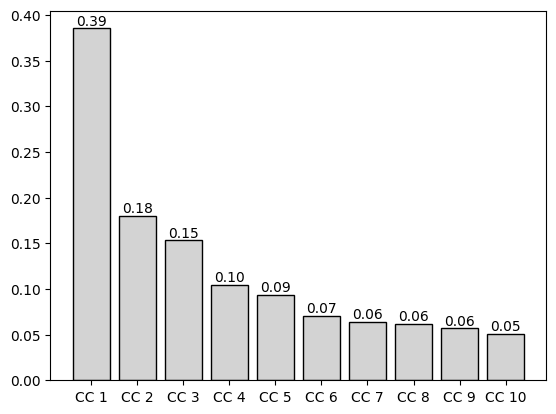

In [13]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

## with lags

dec.x_var_lags.shape: (33125, 243)
dec.y_var_lags_reduced.shape: (33125, 115)
Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.68786 0.43551 0.40293 0.27123 0.25526 0.1962  0.18183 0.17427 0.1594
 0.14827]
% Shared Variance: [0.47315 0.18967 0.16235 0.07357 0.06516 0.03849 0.03306 0.03037 0.02541
 0.02198]


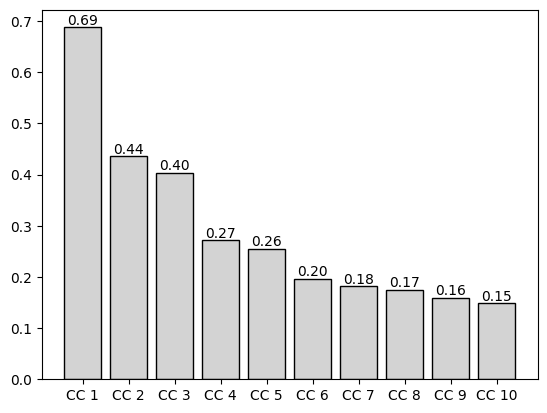

In [14]:
cca_lags = cca_class.CCAclass(X1=dec.x_var_lags.drop(columns='bin'), X2=dec.y_var_lags_reduced, lagging_included=True)
print(f'dec.x_var_lags.shape: {dec.x_var_lags.shape}')
print(f'dec.y_var_lags_reduced.shape: {dec.y_var_lags_reduced.shape}')
cca_lags.conduct_cca()

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## compare lag vs no lag

In [9]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'with_lags'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

In [ ]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [11]:
# choose no lag
cca_inst = cca_no_lag

In [12]:
# choose lags
cca_inst = cca_lags

## loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

## distribution of each feature

In [ ]:
cca_inst.X2_sc.shape

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## test for p values

In [ ]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

## compute explained variance

In [ ]:
cca2.compute_ev([test1, test2])

In [ ]:
stop pls

# train test split

## no lag

Training CCA, kernel = None, regularization = 0.1000, 10 components


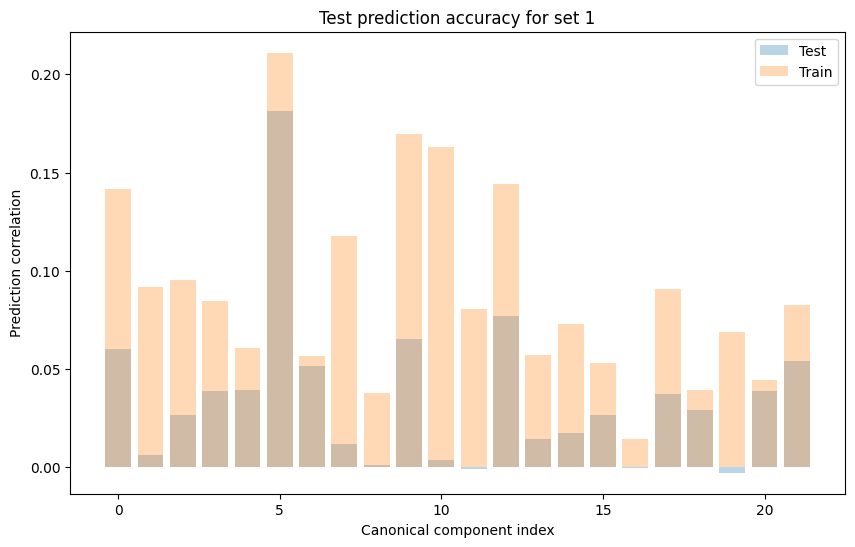

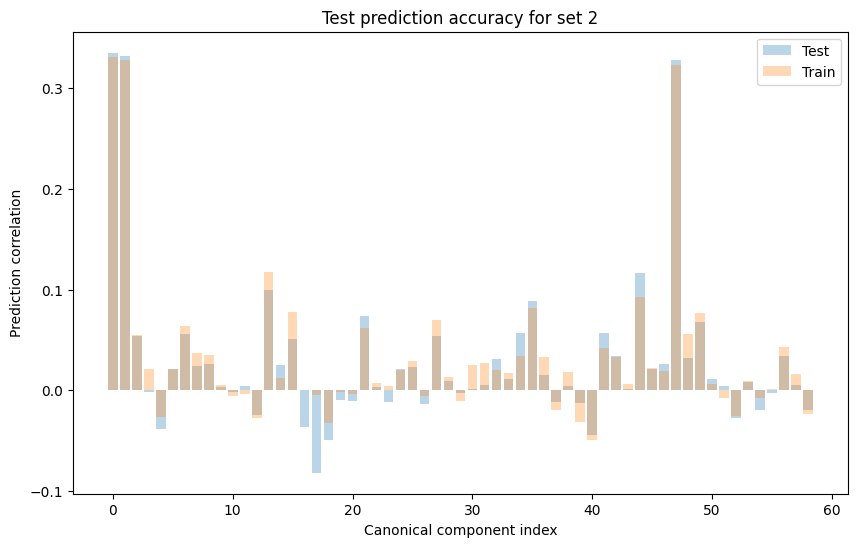

<Figure size 1000x600 with 0 Axes>

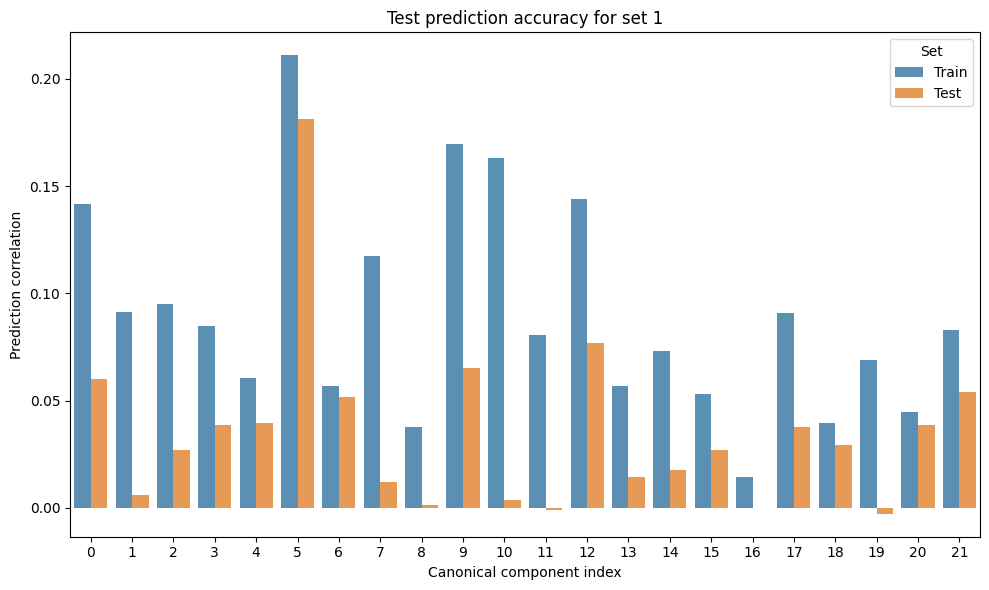

<Figure size 1000x600 with 0 Axes>

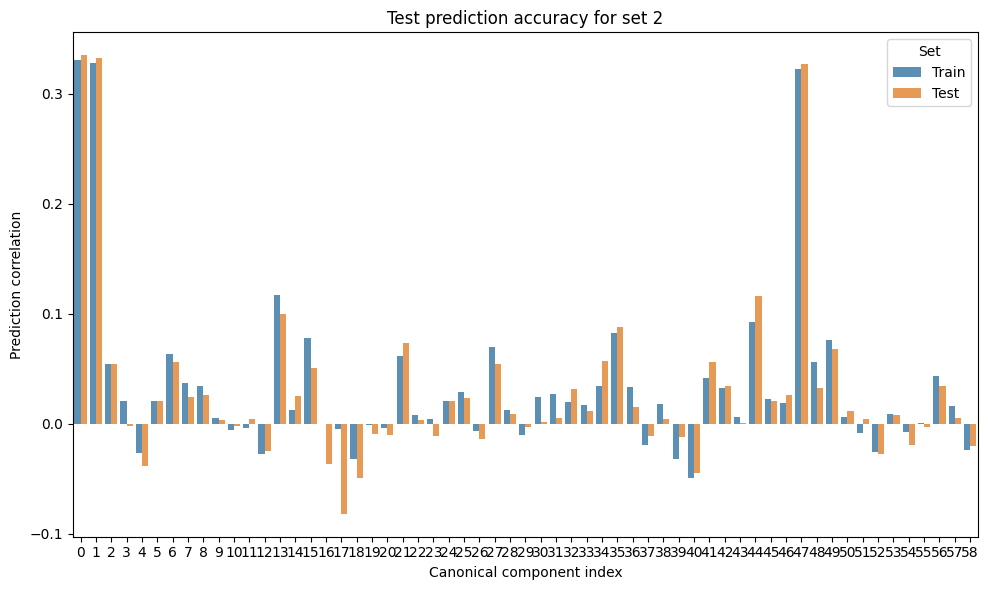

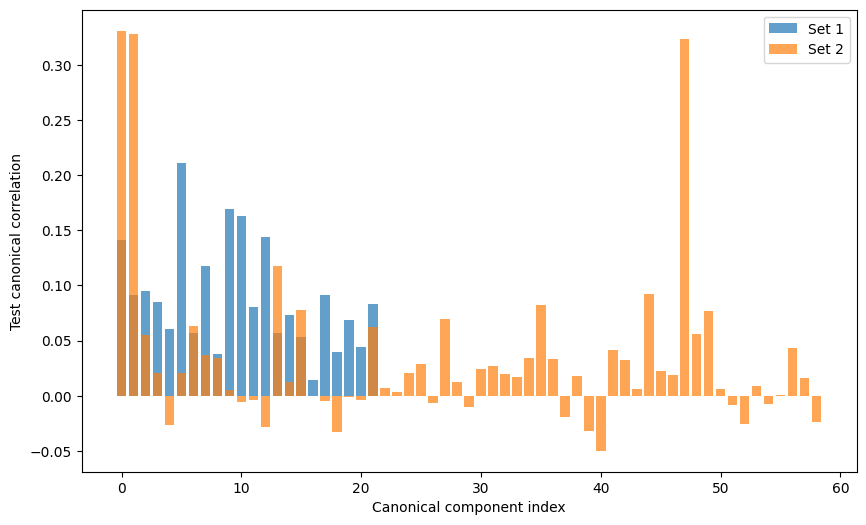

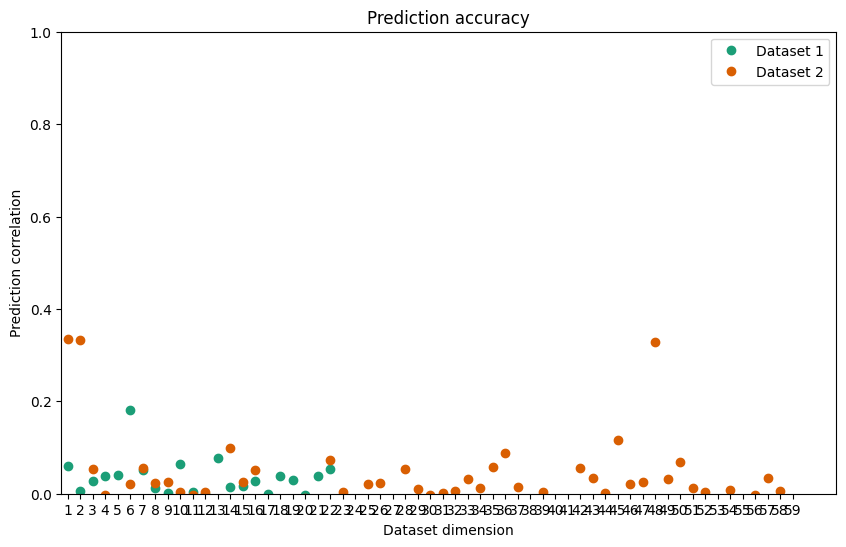

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_no_lag.X1_sc, cca_no_lag.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0.1, numCC = nComponents)
cca2.train([train1, train2])

cca_no_lag.traincorrs = cca2.validate([train1, train2])
cca_no_lag.testcorrs = cca2.validate([test1, test2])

cca_utils.plot_cca_prediction_accuracy_train_test_bars(cca_no_lag.traincorrs, cca_no_lag.testcorrs)
cca_utils.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_no_lag.traincorrs, cca_no_lag.testcorrs)
cca_utils.plot_cca_prediction_accuracy_test_w_bars(cca_no_lag.traincorrs)
cca_utils.plot_cca_prediction_accuracy_w_scatter(cca_no_lag.testcorrs)

In [ ]:
from cca_zoo.models import SCCA

ModuleNotFoundError: No module named 'cca_zoo.models'

## w lags

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_lags.X1_sc, cca_lags.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])

cca_lags.traincorrs = cca2.validate([train1, train2])
cca_lags.testcorrs = cca2.validate([test1, test2])

cca_utils.plot_cca_prediction_accuracy_train_test_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_utils.plot_cca_prediction_accuracy_train_test_stacked_bars(cca_lags.traincorrs, cca_lags.testcorrs)
cca_utils.plot_cca_prediction_accuracy_test_w_bars(cca_lags.traincorrs)
cca_utils.plot_cca_prediction_accuracy_w_scatter(cca_lags.testcorrs)

## compare lags vs no lag

In [23]:
def plot_cca_prediction_accuracy_train_test_bars_for_lags_and_no_lags(lags_testcorrs, lags_traincorrs, no_lags_testcorrs, no_lags_traincorrs):
    for i in range(2):
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(lags_testcorrs[i])), lags_testcorrs[i], alpha=0.3, label='Test with lags')
        plt.bar(range(len(no_lags_testcorrs[i])), no_lags_testcorrs[i], alpha=0.3, label='Test without lags')
        plt.xlabel('Canonical component index')
        plt.ylabel('Prediction correlation')
        plt.title(f'Test prediction accuracy for set {i+1}')
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 6))
        plt.bar(range(len(lags_traincorrs[i])), lags_traincorrs[i], alpha=0.3, label='Train with lags')
        plt.bar(range(len(no_lags_traincorrs[i])), no_lags_traincorrs[i], alpha=0.3, label='Train without lags')
        plt.xlabel('Canonical component index')
        plt.ylabel('Prediction correlation')
        plt.title(f'Test prediction accuracy for set {i+1}')
        plt.legend()
        plt.show()

In [ ]:
cca_utils.plot_cca_prediction_accuracy_train_test_bars_for_lags_and_no_lags(cca_lags.traincorrs, cca_lags.testcorrs, cca_no_lag.traincorrs, cca_no_lag.testcorrs)

# refactored more

In [193]:
combined_X1_df, combined_X2_df = cca_cv_utils.combine_data_to_compare_train_and_test(cca_no_lag, cca_lags)

In [ ]:
cca_cv_utils.plot_lag_offset_train_test_overlap(combined_X2_df, 'DatasetName', mode='lag_offset')


In [ ]:
cca_cv_utils.plot_lag_offset_train_test_overlap(combined_X2_df, 'DatasetName', mode='train_offset')


# K-fold: loading

## run: validate

In [24]:
n_splits = 5
reg = 0.1
n_components = 10

X1 = cca_no_lag.X1_sc
X2 = cca_no_lag.X2_sc

# Canonical correlations
stats_canon = cca_cv_utils.crossvalidated_cca_analysis(X1, X2, n_components=n_components, reg=reg, n_splits=n_splits, 
                                          use_cross_view_corr=False)


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


In [21]:
stats_cross.keys()

dict_keys(['mean_X1_train_corr', 'mean_X1_test_corr', 'mean_X2_train_corr', 'mean_X2_test_corr', 'std_X1_train_corr', 'std_X1_test_corr', 'std_X2_train_corr', 'std_X2_test_corr'])

In [15]:

from sklearn.model_selection import KFold
import numpy as np



# Store loadings for each fold
loadings_X1_train, loadings_X1_test = [], []
loadings_X2_train, loadings_X2_test = [], []

for train_index, test_index in kf.split(X1):
    train1, train2 = X1[train_index], X2[train_index]
    test1, test2 = X1[test_index], X2[test_index]
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([train1, train2])
    
    traincorrs = cca2.validate([train1, train2])
    testcorrs = cca2.validate([test1, test2])
    

    loadings_X1_train.append(traincorrs[0])
    loadings_X2_train.append(traincorrs[1])
    loadings_X1_test.append(testcorrs[0])
    loadings_X2_test.append(testcorrs[1])

# Convert to arrays
loadings_X1_train = np.array(loadings_X1_train)
loadings_X2_train = np.array(loadings_X2_train)
loadings_X1_test = np.array(loadings_X1_test)
loadings_X2_test = np.array(loadings_X2_test)


mean_X1_train = loadings_X1_train.mean(axis=0).reshape(-1, 1)
std_X1_train = loadings_X1_train.std(axis=0).reshape(-1, 1)
mean_X1_test = loadings_X1_test.mean(axis=0).reshape(-1, 1)
std_X1_test = loadings_X1_test.std(axis=0).reshape(-1, 1)

mean_X2_train = loadings_X2_train.mean(axis=0).reshape(-1, 1)
std_X2_train = loadings_X2_train.std(axis=0).reshape(-1, 1)
mean_X2_test = loadings_X2_test.mean(axis=0).reshape(-1, 1)
std_X2_test = loadings_X2_test.std(axis=0).reshape(-1, 1)

Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


## run: loading

In [47]:
from sklearn.model_selection import KFold
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

X1 = cca_no_lag.X1_sc
X2 = cca_no_lag.X2_sc
nComponents = 10

# Store loadings for each fold
loadings_X1_train, loadings_X1_test = [], []
loadings_X2_train, loadings_X2_test = [], []

for train_index, test_index in kf.split(X1):
    train1, train2 = X1[train_index], X2[train_index]
    test1, test2 = X1[test_index], X2[test_index]
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([train1, train2])
    
    # Canonical variates for training data
    U_train, V_train = cca2.comps[0], cca2.comps[1]
    # Canonical variates for test data (project using learned weights)
    U_test = np.dot(test1, cca2.ws[0])
    V_test = np.dot(test2, cca2.ws[1])
    
    # Compute loadings for training data
    load_X1_train = np.corrcoef(train1.T, U_train.T)[:train1.shape[1], train1.shape[1]:]
    load_X2_train = np.corrcoef(train2.T, V_train.T)[:train2.shape[1], train2.shape[1]:]
    # Compute loadings for test data
    load_X1_test = np.corrcoef(test1.T, U_test.T)[:test1.shape[1], test1.shape[1]:]
    load_X2_test = np.corrcoef(test2.T, V_test.T)[:test2.shape[1], test2.shape[1]:]
    
    loadings_X1_train.append(load_X1_train)
    loadings_X2_train.append(load_X2_train)
    loadings_X1_test.append(load_X1_test)
    loadings_X2_test.append(load_X2_test)

# Convert to arrays
loadings_X1_train = np.array(loadings_X1_train)
loadings_X2_train = np.array(loadings_X2_train)
loadings_X1_test = np.array(loadings_X1_test)
loadings_X2_test = np.array(loadings_X2_test)


mean_X1_train = loadings_X1_train.mean(axis=0)
std_X1_train = loadings_X1_train.std(axis=0)
mean_X1_test = loadings_X1_test.mean(axis=0)
std_X1_test = loadings_X1_test.std(axis=0)

mean_X2_train = loadings_X2_train.mean(axis=0)
std_X2_train = loadings_X2_train.std(axis=0)
mean_X2_test = loadings_X2_test.mean(axis=0)
std_X2_test = loadings_X2_test.std(axis=0)

Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components
Training CCA, kernel = None, regularization = 0.1000, 10 components


## plot all vars

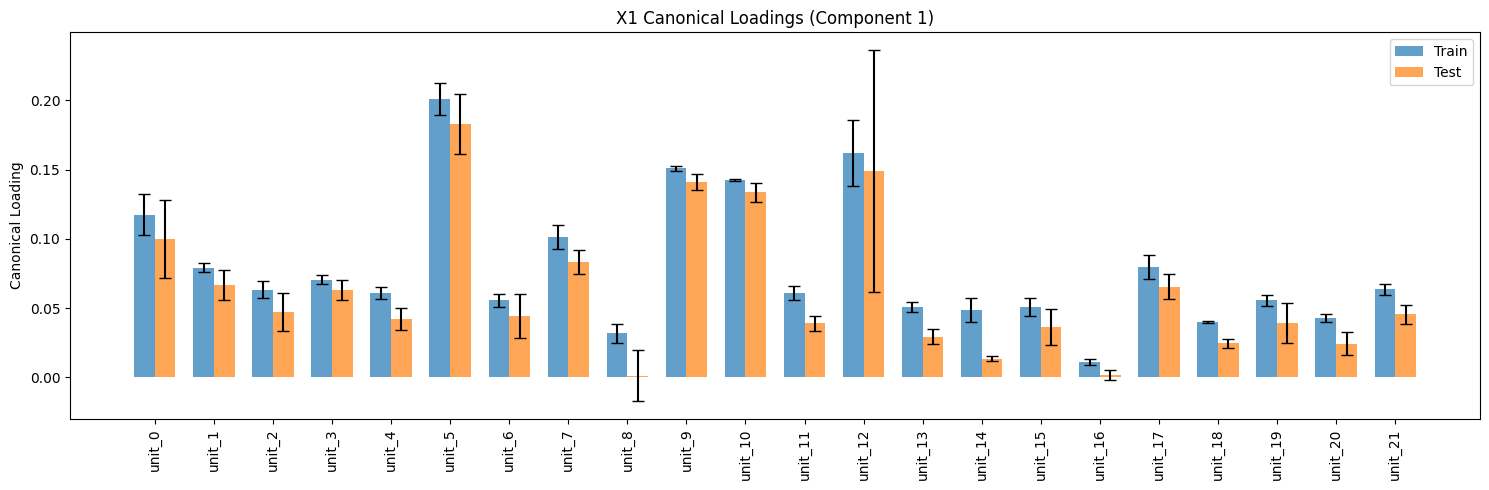

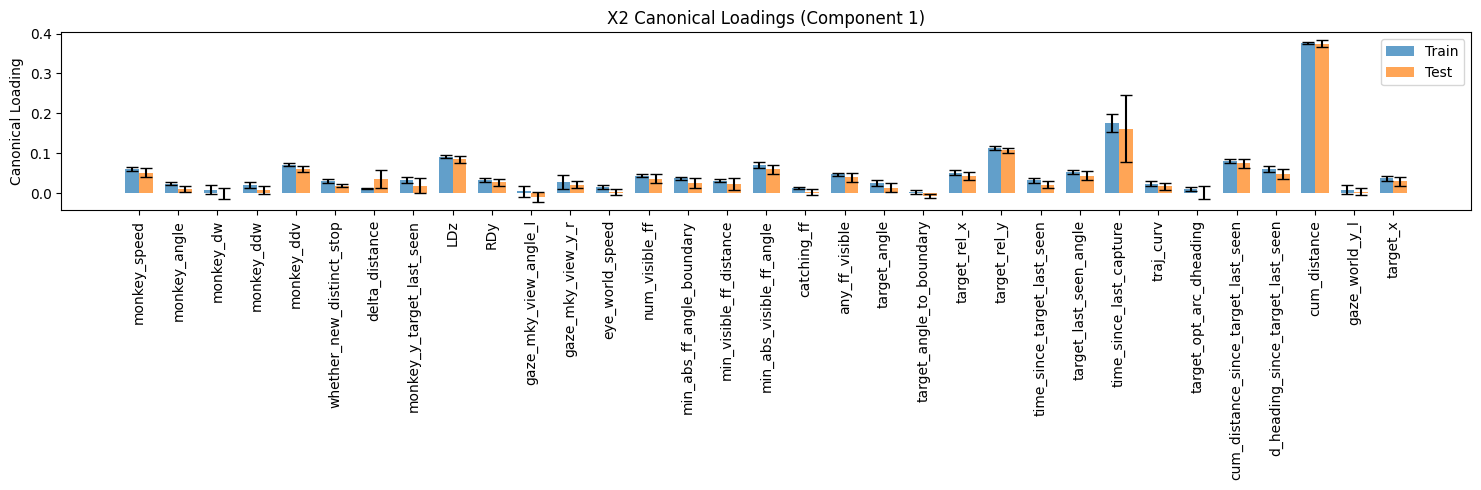

In [25]:
import matplotlib.pyplot as plt

# Use your variable names if available, otherwise use generic names
x1_labels = getattr(cca_no_lag.X1, 'columns', [f'X1_{i+1}' for i in range(mean_X1_train.shape[0])])
x2_labels = getattr(cca_no_lag.X2, 'columns', [f'X2_{i+1}' for i in range(mean_X2_train.shape[0])])

component = 0  # first canonical component

def plot_loadings(stats_canon, labels, data_type='X1'):
    mean_train, std_train, mean_test, std_test = stats_canon[f'mean_{data_type}_train_corr'], stats_canon[f'std_{data_type}_train_corr'], stats_canon[f'mean_{data_type}_test_corr'], stats_canon[f'std_{data_type}_test_corr']
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(x - width/2, mean_train[:, component], width, yerr=std_train[:, component], label='Train', alpha=0.7, capsize=4)
    ax.bar(x + width/2, mean_test[:, component], width, yerr=std_test[:, component], label='Test', alpha=0.7, capsize=4)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel('Canonical Loading')
    ax.set_title(f'{data_type} Canonical Loadings (Component 1)')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_loadings(stats_canon, x1_labels, 'X1')
plot_loadings(stats_canon, x2_labels, 'X2')

## plot significant vars

## X1

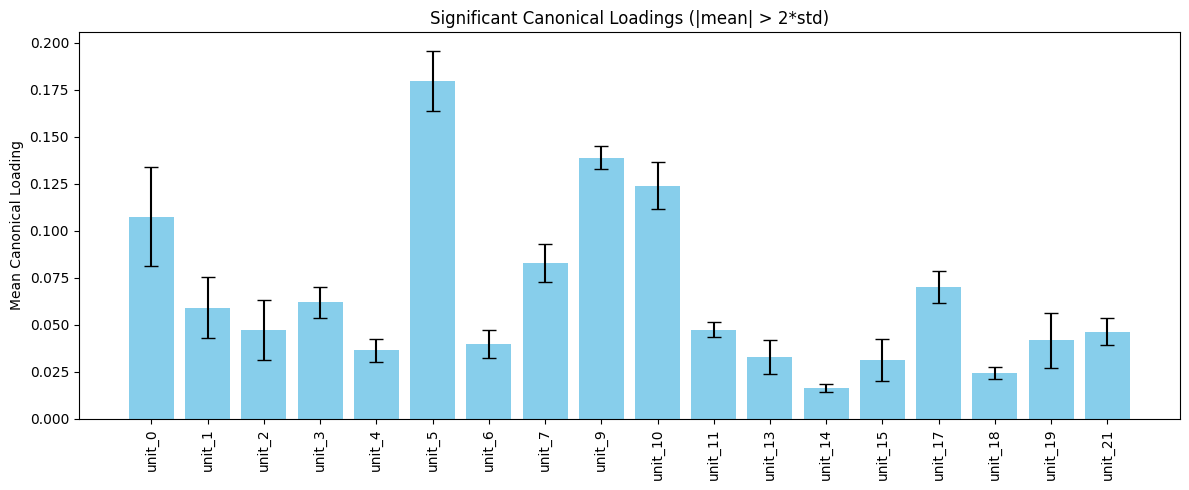

In [58]:
# mean_X1_test, std_X1_test: shape (n_features, n_components)
threshold = 2  # "significant" if mean > 2*std
significant_mask = np.abs(mean_X1_test[:, 0]) > threshold * std_X1_test[:, 0]

# Use your variable names if available
x1_labels = getattr(cca_no_lag.X1, 'columns', [f'X1_{i+1}' for i in range(mean_X1_test.shape[0])])

component = 0  # which canonical component

# Mask for significant variables
significant_mask = np.abs(mean_X1_test[:, component]) > 2 * std_X1_test[:, component]

# Filter data
sig_means = mean_X1_test[significant_mask, component]
sig_stds = std_X1_test[significant_mask, component]
sig_labels = np.array(x1_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title('Significant Canonical Loadings (|mean| > 2*std)')
plt.tight_layout()
plt.show()

## X2

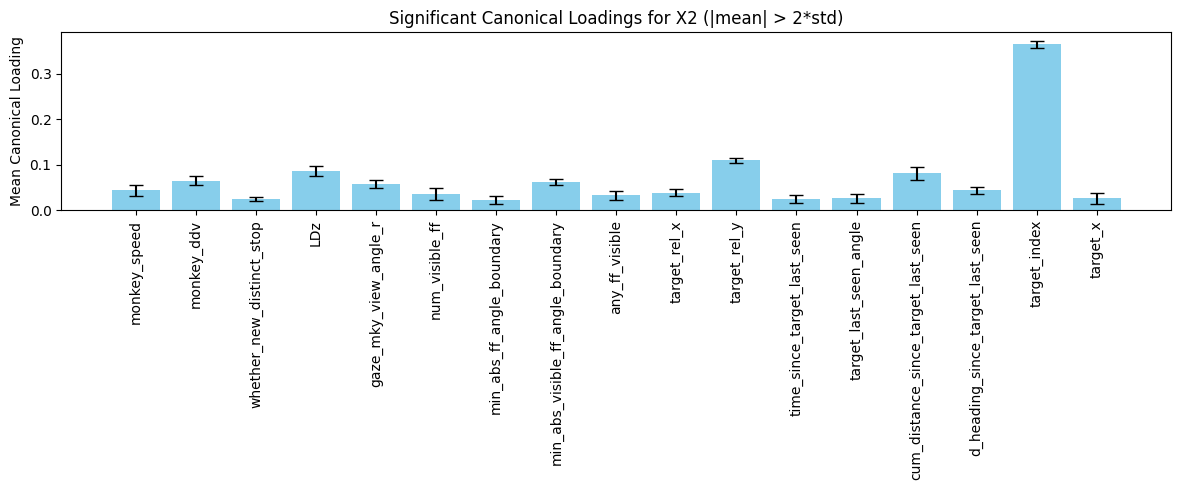

In [59]:
# mean_X2_test, std_X2_test: shape (n_features, n_components)
threshold = 2  # "significant" if mean > 2*std

# Use your variable names if available
x2_labels = getattr(cca_no_lag.X2, 'columns', [f'X2_{i+1}' for i in range(mean_X2_test.shape[0])])

component = 0  # which canonical component

# Mask for significant variables
significant_mask = np.abs(mean_X2_test[:, component]) > threshold * std_X2_test[:, component]

# Filter data
sig_means = mean_X2_test[significant_mask, component]
sig_stds = std_X2_test[significant_mask, component]
sig_labels = np.array(x2_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title('Significant Canonical Loadings for X2 (|mean| > 2*std)')
plt.tight_layout()
plt.show()

## Sort by |mean|/std (signal-to-noise ratio):

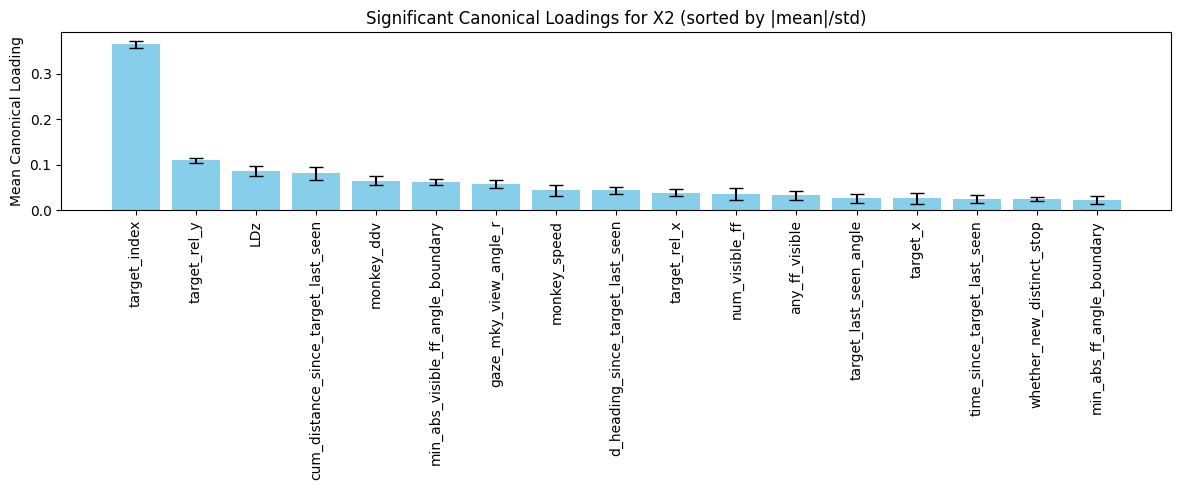

In [60]:
import numpy as np
import matplotlib.pyplot as plt

threshold = 2
component = 0

x2_labels = getattr(cca_no_lag.X2, 'columns', [f'X2_{i+1}' for i in range(mean_X2_test.shape[0])])

# Mask for significant variables
significant_mask = np.abs(mean_X2_test[:, component]) > threshold * std_X2_test[:, component]

# Filter data
sig_means = mean_X2_test[significant_mask, component]
sig_stds = std_X2_test[significant_mask, component]
sig_labels = np.array(x2_labels)[significant_mask]

# Compute significance score (|mean|/std)
# sig_score = np.abs(sig_means) / sig_stds
sig_score = np.abs(sig_means)


# Sort by significance score (descending)
sorted_idx = np.argsort(-sig_score)


sig_means = sig_means[sorted_idx]
sig_stds = sig_stds[sorted_idx]
sig_labels = sig_labels[sorted_idx]
sig_score = sig_score[sorted_idx]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title('Significant Canonical Loadings for X2 (sorted by |mean|/std)')
plt.tight_layout()
plt.show()

## with basis function

In [22]:
import numpy as np

def power_features(x, powers=[2, 0.5]):
    # x: shape (n_samples, n_features)
    features = [x]  # start with original features
    for p in powers:
        if p == 1:
            continue  # skip the original features (already included)
        # For square root, ensure sign is preserved
        if p < 1:
            features.append(np.sign(x) * np.abs(x) ** p)
        else:
            features.append(x ** p)
    return np.concatenate(features, axis=1)

In [27]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.cross_decomposition import CCA
import numpy as np

transformers = [
    # ('none', lambda x: x),
    ('poly2', lambda x: power_features(x, powers=[2, 0.5])),
    ('log', lambda x: np.log1p(np.abs(x)) * np.sign(x))
]

X1 = cca_no_lag.X1_sc
X2 = cca_no_lag.X2_sc

best_score = -np.inf
best_combo = None

n_splits = 3    
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for name1, trans1 in transformers:
    for name2, trans2 in transformers:
        train_scores = []
        test_scores = []
        count = 0
        for train_idx, test_idx in kf.split(X1):
            count += 1
            print(f'{count} out of {n_splits} folds for {name1} and {name2}')
            X1_train, X1_test = X1[train_idx], X1[test_idx]
            X2_train, X2_test = X2[train_idx], X2[test_idx]
            # Apply transforms
            X1_train_t = trans1(X1_train)
            X1_test_t = trans1(X1_test)
            X2_train_t = trans2(X2_train)
            X2_test_t = trans2(X2_test)
            # Fit CCA
            cca = CCA(n_components=2)
            cca.fit(X1_train_t, X2_train_t)
            X1_c, X2_c = cca.transform(X1_test_t, X2_test_t)
            
            # get train scores
            X1_c_train, X2_c_train = cca.transform(X1_train_t, X2_train_t)
            train_score = np.mean([np.corrcoef(X1_c_train[:, i], X2_c_train[:, i])[0, 1] for i in range(2)])
            train_scores.append(train_score)
            
            # Score: mean canonical correlation
            score = np.mean([np.corrcoef(X1_c[:, i], X2_c[:, i])[0, 1] for i in range(2)])
            test_scores.append(score)
        mean_score = np.mean(test_scores)
        print(f"X1: {name1}, X2: {name2}, mean train score: {np.mean(train_scores):.3f}, mean CV score: {mean_score:.3f}")
        if mean_score > best_score:
            best_score = mean_score
            best_combo = (name1, name2)

print("Best combo:", best_combo, "with score:", best_score)

1 out of 3 folds for poly2 and poly2
2 out of 3 folds for poly2 and poly2
3 out of 3 folds for poly2 and poly2
X1: poly2, X2: poly2, mean train score: 0.407, mean CV score: 0.263
1 out of 3 folds for poly2 and log
2 out of 3 folds for poly2 and log
3 out of 3 folds for poly2 and log
X1: poly2, X2: log, mean train score: 0.341, mean CV score: 0.328
1 out of 3 folds for log and poly2
2 out of 3 folds for log and poly2
3 out of 3 folds for log and poly2
X1: log, X2: poly2, mean train score: 0.403, mean CV score: 0.308
1 out of 3 folds for log and log
2 out of 3 folds for log and log
3 out of 3 folds for log and log
X1: log, X2: log, mean train score: 0.337, mean CV score: 0.328
Best combo: ('poly2', 'log') with score: 0.32849114025668413


In [ ]:
stop!

(33125, 59)

# permutation test (later)

In [ ]:
import numpy as np
from tqdm import tqdm

n_permutations = 1000
component = 0  # which canonical component
n_features = X1.shape[1]

# Store observed loadings
observed_loadings = mean_X1_test[:, component]  # or use your preferred estimate

# Store null distributions
null_loadings = np.zeros((n_features, n_permutations))

for perm in tqdm(range(n_permutations)):
    # Shuffle rows of X1
    X1_perm = np.random.permutation(X1)
    # Fit CCA on permuted X1 and original X2
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([X1_perm, X2])
    U_perm = np.dot(X1_perm, cca2.ws[0])
    # Compute loadings for permuted data
    load_X1_perm = np.corrcoef(X1_perm.T, U_perm.T)[:n_features, n_features:]
    null_loadings[:, perm] = load_X1_perm[:, component]

# Compute two-sided p-values
p_values = np.mean(np.abs(null_loadings) >= np.abs(observed_loadings[:, None]), axis=1)

In [ ]:
import matplotlib.pyplot as plt

alpha = 0.05  # significance level
significant_mask = p_values < alpha

sig_means = observed_loadings[significant_mask]
sig_stds = std_X1_test[significant_mask, component]  # or use std from CV
sig_labels = np.array(x1_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title(f'Significant Canonical Loadings (p < {alpha})')
plt.tight_layout()
plt.show()

# Now: could you use neural data to decode target position?

what about 2nd target's position?
(can either use 1st target's decoder, or train and separate decoder for 2nd target)

also...try GPFA at some point 